In [35]:
import sys
import os
import importlib   

from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad
from torch.utils.data import Dataset

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import recurrent_nn as rnn
importlib.reload(rnn)

<module 'recurrent_nn' from '/home/lucas/Desktop/PFE/MyCode/NeuralNetworks/recurrent_nn.py'>

In [36]:
## Domain with a corner singularity at y=0 ##

class Corner_Singularity_2D(Dataset):
    def __init__(self, nb_points_in_omega=1000, nb_points_on_boundary=500, normal=False, lower_bound_xy=[-1, -1], uper_bound_xy=[1, 1]):

        self.lower_bound_xy = lower_bound_xy
        self.upper_bound_xy = uper_bound_xy
        self.squared_grid_size = 19
        self.normal = normal

        self.nb_points_in_omega = nb_points_in_omega
        self.nb_points_on_boundary = nb_points_on_boundary
        self.omega_coordinates, self.boundary_coordinates = self._create_points_in_domain(self.nb_points_in_omega, self.nb_points_on_boundary, self.lower_bound_xy, self.upper_bound_xy, self.normal)

        self.omega_uniform_coordinates, self.boundary_uniform_coordinates, self.uniform_all_points = self._create_uniform_grid([self.squared_grid_size, self.squared_grid_size], self.lower_bound_xy, self.upper_bound_xy)

    def __getitem__(self, index):
        return self.omega_coordinates[index]
    
    def __len__(self):
        return self.nb_points_in_omega + self.nb_points_on_boundary

    def  _create_points_in_domain(self, nb_points_in_omega, nb_points_on_boundary, lower_bound_xy, upper_bound_xy, normal, tol_boundary_corner=1e-6, tol_boundary_square=1e-6):
        xmin, ymin = lower_bound_xy
        xmax, ymax = upper_bound_xy
        if normal:
            x_points_in_omega = np.random.normal(0, 0.66, nb_points_in_omega)
            y_points_in_omega = np.random.normal(0, 0.66, nb_points_in_omega)
            omega_coordinates = np.vstack((x_points_in_omega, y_points_in_omega)).T
            omega_coordinates = omega_coordinates[(omega_coordinates[:, 0] >= xmin) & (omega_coordinates[:, 0] <= xmax)
                                                  & (omega_coordinates[:, 1] >= ymin) & (omega_coordinates[:, 1] <= ymax)]
        else:
            x_points_in_omega = np.random.uniform(xmin+tol_boundary_square, xmax-tol_boundary_square, nb_points_in_omega)
            y_points_in_omega = np.random.uniform(ymin+tol_boundary_square, ymax-tol_boundary_square, nb_points_in_omega)
            omega_coordinates = np.vstack((x_points_in_omega, y_points_in_omega)).T

        corner_singularity_mask = ~((-tol_boundary_corner <= omega_coordinates[:, 1]) &
                                    (omega_coordinates[:, 1] <= tol_boundary_corner) &
                                    (0 <= omega_coordinates[:, 0]) &
                                    (omega_coordinates[:, 0] <= xmax-tol_boundary_square))
        omega_coordinates = omega_coordinates[corner_singularity_mask]

        nb_points_per_boundary = nb_points_on_boundary // 5
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, nb_points_per_boundary), np.ones(nb_points_per_boundary)*ymin
        x_top, y_top = np.random.uniform(xmin, xmax, nb_points_per_boundary), np.ones(nb_points_per_boundary)*ymax
        x_right, y_right = np.ones(nb_points_per_boundary)*xmax, np.random.uniform(ymin, ymax, nb_points_per_boundary)
        x_left, y_left = np.ones(nb_points_per_boundary)*xmin, np.random.uniform(ymin, ymax, nb_points_per_boundary)
        x_corner, y_corner = np.random.uniform(0, xmax, nb_points_per_boundary), np.zeros(nb_points_per_boundary)

        x_boundary = np.concatenate((x_bottom, x_top, x_right, x_left, x_corner))
        y_boundary = np.concatenate((y_bottom, y_top, y_right, y_left, y_corner))

        boundary_coordinates = np.vstack((x_boundary, y_boundary)).T

        self.nb_points_on_boundary = len(boundary_coordinates)
        self.nb_points_in_omega = len(omega_coordinates)

        return omega_coordinates, boundary_coordinates

    def _create_uniform_grid(self, grid_size, lower_bound_xy, upper_bound_xy):
        mesh = RectangleMesh(Point(lower_bound_xy[0], lower_bound_xy[1]), Point(upper_bound_xy[0], upper_bound_xy[1]), grid_size[0], grid_size[1])
        mesh_coordinates = mesh.coordinates()

        boundary_mask = [(x, y) for x, y in mesh_coordinates if ((x == -1) or (x == 1) or (y == -1) or (y == 1))]
        extra_points_for_boundary = [(x, 0) for x in np.linspace(0, 1, 40)] 
        boundary_mask.extend(extra_points_for_boundary)
        omega_mask = [(x, y) for x, y in mesh_coordinates if not ((y == 0 and 0 <= x <= 1) or (x == -1) or (x == 1) or (y == -1) or (y == 1))]

        boundary_coordinates = np.array(boundary_mask)
        boundary_coordinates = boundary_coordinates[np.lexsort((boundary_coordinates[:, 0], boundary_coordinates[:, 1]))]
        omega_coordinates = np.array(omega_mask)

        return omega_coordinates, boundary_coordinates, mesh_coordinates

    def plot_domain(self, label=True):
        plt.scatter(self.omega_coordinates[:, 0], self.omega_coordinates[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_coordinates[:, 0], self.boundary_coordinates[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        if label:
            plt.legend()
        plt.show()   

In [37]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    negative_mask = phi < 0
    phi[negative_mask] += 2 * np.pi
    return(rho, phi)

def u_true(x):
    x, y = x[:, 0], x[:, 1]
    r, theta = cart2pol(x, y)
    return r**(1/2) * np.sin(theta/2)

def f_true(x):
    return np.zeros(x.shape[0])

def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [38]:
def H1_norm(u):
    grad_ux, grad_uy = np.gradient(u)
    grad_norm_squared = grad_ux**2 + grad_uy**2
    return np.sqrt(np.sum(grad_norm_squared) + np.sum(u**2))

def assess_solution(model, evaluation_domain, train_loss, display_results=False):
    squared_grid_size = evaluation_domain.squared_grid_size
    evaluation_domain_points = torch.FloatTensor(evaluation_domain.uniform_all_points)

    model.eval()

    u_pred = (model(evaluation_domain_points).detach().numpy()).reshape(squared_grid_size+1, squared_grid_size+1)
    u_exact = (u_true(evaluation_domain_points).detach().numpy()).reshape(squared_grid_size+1, squared_grid_size+1)

    diff_abs = np.abs(u_exact - u_pred)
    diff_l2 = np.linalg.norm(diff_abs.flatten())
    diff_h1 = H1_norm(u_exact - u_pred)

    err_l2_pred, err_l2_true_sol = np.linalg.norm(u_pred.flatten()), np.linalg.norm(u_exact.flatten())
    err_h1_pred, err_h1_true_sol = H1_norm(u_pred), H1_norm(u_exact)
    err_relative_l2 = diff_l2 / np.linalg.norm(u_exact.flatten())
    err_relative_h1 = diff_h1 / H1_norm(u_exact)
    
    if display_results:

        print(f"Mean absolute difference: {np.mean(diff_abs)}")
        print(f"Norm L2 of the true solution: {err_l2_true_sol} and of the predicted solution: {err_l2_pred}")
        print(f"Norm H1 of the true solution: {err_h1_true_sol} and of the predicted solution: {err_h1_pred}")
        print(f"Norm L2 of the relative error: {err_relative_l2}")
        print(f"Norm H1 of the relative error: {err_relative_h1}")

        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        im0 = axes[0].imshow(u_exact, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
        axes[0].set_title('Exact solution')
        fig.colorbar(im0, ax=axes[0], shrink=0.6)

        im1 = axes[1].imshow(u_pred, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
        axes[1].set_title('Predicted solution')
        fig.colorbar(im1, ax=axes[1], shrink=0.6)

        im2 = axes[2].imshow(diff_abs, cmap='jet', extent=[-1, 1, -1, 1])
        axes[2].set_title('Absolute difference')
        fig.colorbar(im2, ax=axes[2], shrink=0.6)

        plt.tight_layout()
        plt.show()

        fig_train, ax_train = plt.subplots(1, 1, figsize=(12, 5))
        ax_train.plot(train_loss)
        ax_train.set_xlabel('Number of iterations')
        ax_train.set_ylabel('Loss')
        ax_train.set_title('Training loss')
        plt.show()

    else : 
        return err_relative_l2, err_relative_h1

In [39]:
## DEVICE CHECK ##

if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


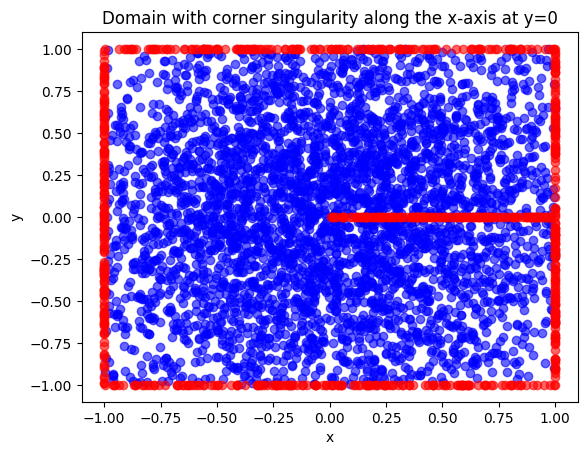

In [40]:
## Always check that we have the corner singularity in the domain ##

omega = Corner_Singularity_2D(5000, 750, normal=True)
omega.plot_domain(False)
ix_omega = omega.omega_coordinates
ix_boundary = omega.boundary_coordinates
true_boundary = torch.FloatTensor(u_true(ix_boundary)).reshape(len(ix_boundary),1) 

In [41]:
## Loss function ##

class DeepRitzLoss(torch.nn.Module):
    def __init__(self):
        super(DeepRitzLoss, self).__init__()
        self.mse = torch.nn.MSELoss()
        self.loss = 0.
    
    def forward(self, x_in_omega, output_ux_in_omega, true_operator_x, output_on_boundary, true_value_on_boundary, boundary_regulizer=500):
        grad_u = grad(inputs=x_in_omega, outputs=output_ux_in_omega, grad_outputs=torch.ones_like(output_ux_in_omega), create_graph=True, allow_unused=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]

        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = true_operator_x*output_ux_in_omega
        boundary_loss = self.mse(output_on_boundary, true_value_on_boundary)

        total_loss = 4*0.5*torch.mean(physical_term1) - 4*torch.mean(physical_term2) + boundary_regulizer*boundary_loss
        self.loss = total_loss.item()
        return total_loss

In [ ]:
## Training recurrent neural network ##

ritz_model = rnn.RitzModel(2)
print(ritz_model.nb_params)
criterion = DeepRitzLoss()
model_optimizer = torch.optim.Adam(ritz_model.parameters(), lr=0.0005)
n_iter_adam = 15000

train_loss_per_iter = []

evaluation_grid = Corner_Singularity_2D()
err_relative_min = float('inf')

for iter_i in range(n_iter_adam):
    ritz_model.train()

    integration_grid = Corner_Singularity_2D(1000, 250, normal=False)
    mc_integration_points_in_omega = torch.FloatTensor(integration_grid.omega_coordinates)
    mc_integration_points_on_boundary = torch.FloatTensor(integration_grid.boundary_coordinates)
    mc_true_boundary = torch.FloatTensor(u_true(mc_integration_points_on_boundary)).reshape(integration_grid.nb_points_on_boundary, 1)
    # mc_true_boundary = torch.zeros(integration_grid.nb_points_on_boundary, 1)

    mc_integration_points_in_omega.requires_grad = True

    fmc_integration_points = torch.FloatTensor(f_true(mc_integration_points_in_omega)).reshape(integration_grid.nb_points_in_omega, 1)

    model_optimizer.zero_grad()

    mc_output_omega = ritz_model(mc_integration_points_in_omega)
    mc_output_boundary = ritz_model(mc_integration_points_on_boundary)
    
    total_loss = criterion(x_in_omega=mc_integration_points_in_omega, output_ux_in_omega=mc_output_omega, true_operator_x=fmc_integration_points, output_on_boundary=mc_output_boundary, true_value_on_boundary=mc_true_boundary, boundary_regulizer=500)
    train_loss_iter_i = total_loss.item()
    
    total_loss.backward()
    model_optimizer.step()

    train_loss_per_iter.append(train_loss_iter_i)

    err_relative_l2, err_relative_h1 = assess_solution(ritz_model, evaluation_grid, train_loss_per_iter)
    err_relative_tot = err_relative_l2 + err_relative_h1

    if err_relative_tot < err_relative_min:
        err_relative = err_relative_tot
        iter_best = iter_i
        torch.save(ritz_model.state_dict(), f'./NeuralNetworks/best_model.pth')

    if iter_i % 25 == 0:
        print(f"Iter {iter_i}, Loss: {train_loss_iter_i}")

811
Iter 0, Loss: 189.45852661132812
Iter 25, Loss: 125.17579650878906
Iter 50, Loss: 69.06534576416016
Iter 75, Loss: 50.47675323486328
Iter 100, Loss: 41.3509635925293
Iter 125, Loss: 31.222936630249023
Iter 150, Loss: 24.279943466186523
Iter 175, Loss: 21.576763153076172
Iter 200, Loss: 20.96543312072754
Iter 225, Loss: 23.129150390625
Iter 250, Loss: 21.33992576599121
Iter 275, Loss: 22.299501419067383
Iter 300, Loss: 24.17722511291504
Iter 325, Loss: 22.842552185058594
Iter 350, Loss: 23.061046600341797
Iter 375, Loss: 21.949708938598633
Iter 400, Loss: 22.849666595458984


Best model found at iteration 9999
0.008462367
Mean absolute difference: 0.00846236664801836
Norm L2 of the true solution: 12.686319351196289 and of the predicted solution: 12.729347229003906
Norm H1 of the true solution: 12.751504898071289 and of the predicted solution: 12.797950744628906
Norm L2 of the relative error: 0.020124217495322227
Norm H1 of the relative error: 0.024565620347857475


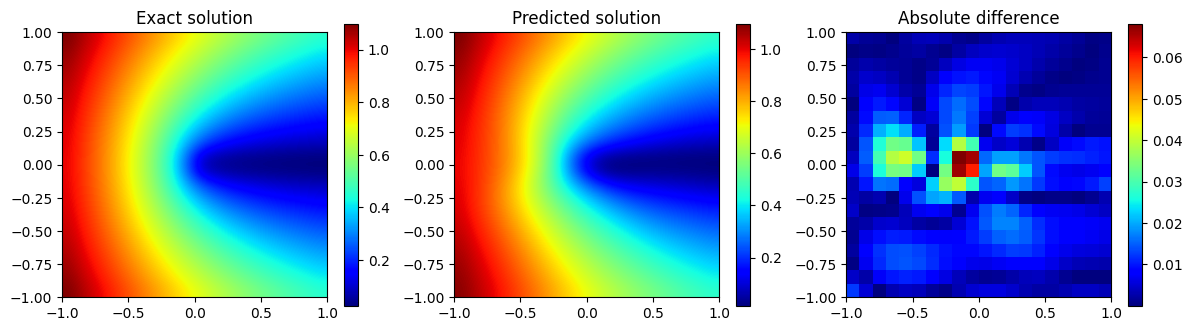

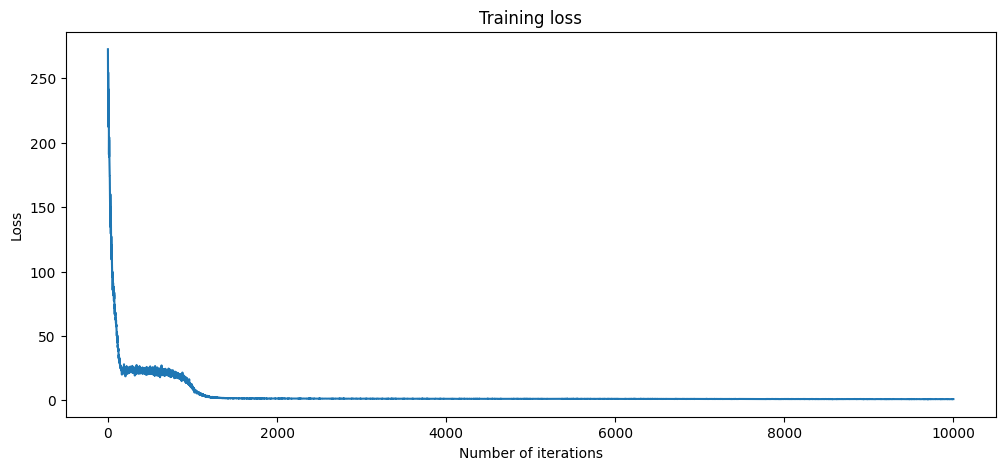

In [33]:
## Results ##

print('Best model found at iteration', iter_best)
best_model = rnn.RitzModel(2)
best_model.load_state_dict(torch.load('./NeuralNetworks/best_model.pth', weights_only=True))
best_model.eval()
assess_solution(best_model, Corner_Singularity_2D(), train_loss_per_iter, display_results=True)